In [6]:
import control
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]

## Define the Model
Define state space matrices: A, B and disturbance

In [2]:
# Numeric values from Table 1, Nitin R. Kapania, J. Chirstian Gerdes(2015)
m_std = 1500
I_z_std = 2250
l_f_std = 1.04
l_r_std = 1.42
C_f_std = 160000
C_r_std = 180000


def generate_A(v_x, L_a, m=m_std, C_f=C_f_std, C_r=C_r_std,
                 l_f=l_f_std, l_r=l_r_std, I_z=I_z_std):
    A_gen = np.array([[0, 1, 0, 0],
                      [0, -1*(C_f+C_r)/(m*v_x),
   L_a*(C_f+C_r)/(m*v_x) + (C_f+C_r)/m 
      + L_a*(L_a+v_x)*(C_f*l_f-C_r*l_r)/(I_z*v_x),
   (C_r*l_r-C_f*l_f)/(m*v_x) 
      - L_a*(l_f**2*C_f+l_r**2*C_r)/(I_z*v_x)],
                      [0, 0, 0, 1],
                      [0, (C_r*l_r-C_f*l_f)/(I_z*v_x),
   (C_f*l_f-C_r*l_r)/(I_z*v_x)*(L_a+v_x),
   -1*((l_f**2*C_f+l_r**2*C_r)/(I_z*v_x))]
                     ]).reshape(4, 4)
    return A_gen

def generate_B(L_a, m=m_std, C_f=C_f_std, l_f=l_f_std, I_z=I_z_std):
    B_gen = np.array([0, C_f/m + L_a*l_f*C_f/I_z,
                      0, l_f*C_f/I_z]).reshape(4, 1)
    return B_gen

def generate_dis(v_x, L_a, m=m_std, C_f=C_f_std, C_r=C_r_std,
                 l_f=l_f_std, l_r=l_r_std, I_z=I_z_std):
    dis_gen = np.array([0, (C_r*l_r-C_f*l_f)/(m*v_x)
        - v_x - L_a*(l_f**2*C_f+l_r**2*C_r)/(I_z*v_x)]).reshape(4, 1)
    return dis_gen


## Inspect the Model

For manually analyzing, use below one.

In [3]:
v_slider = widgets.FloatSlider(min=0.5, max=120, step=0.05, value=15)
La_slider = widgets.FloatSlider(min=0, max=100, step=0.05, value=10)

@widgets.interact_manual()
def plot(v=v_slider, L_a=La_slider):
    A = generate_A(v, L_a)
    B = generate_B(L_a)

    for output_no in range(A.shape[0]):
        C = np.zeros((1, 4))
        C[0, output_no] = 1
        D = 0

        sys = control.ss(A, B, C, D)
        poles, zeros = control.pzmap(sys)
        plt.title("Pole Zero Map ~ Output "+ str(output_no))
        print("\nFor output", output_no)
        print("   Poles:", poles)
        print("   Zeros:", zeros)

interactive(children=(FloatSlider(value=15.0, description='v', max=120.0, min=0.5, step=0.05), FloatSlider(val…

To understand the effect of L_a and v_x on;
    * Do a grid search
    * Obtain poles and zeros for the combinations

### Effect of $L_{a}$ & $v_{x}$ on $y_{el}$

In [4]:
C = np.array([1, 0, 0, 0]).reshape(1, 4)
D = 0
    
v_values = np.linspace(5, 40, 20)
La_values = np.linspace(1, 25, 20)

pz_wrt_v = {}
for v in v_values:
    v_La = {}
    pz_wrt_v[v] = v_La
    for L_a in La_values:        
        A = generate_A(v, L_a)
        B = generate_B(L_a)

        sys = control.ss(A, B, C, D)
        poles, zeros = control.pzmap(sys, Plot=False)
        v_La[L_a] = (poles, zeros)
        
pz_wrt_La = {}
for L_a in La_values:
    La_v = {}
    pz_wrt_La[L_a] = La_v
    for v in v_values:        
        A = generate_A(v, L_a)
        B = generate_B(L_a)

        sys = control.ss(A, B, C, D)
        poles, zeros = control.pzmap(sys, Plot=False)
        La_v[v] = (poles, zeros)

Observe the effect of different L_a for some selected v_x;

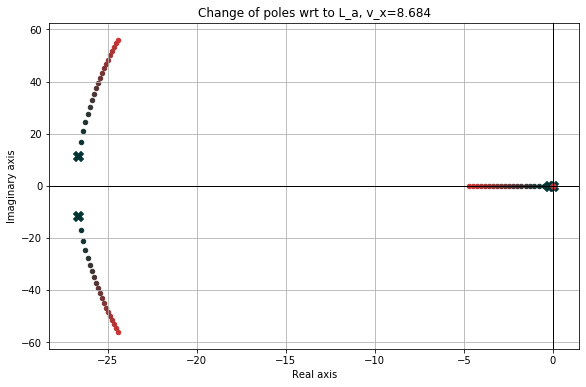

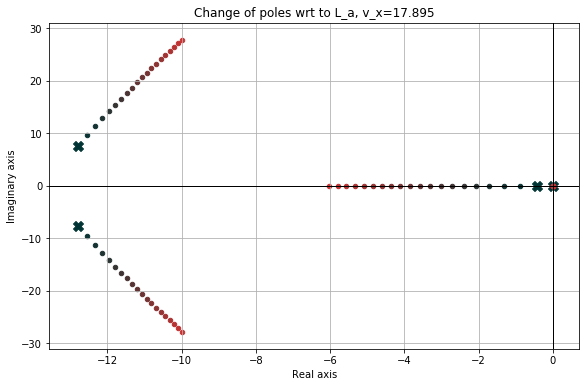

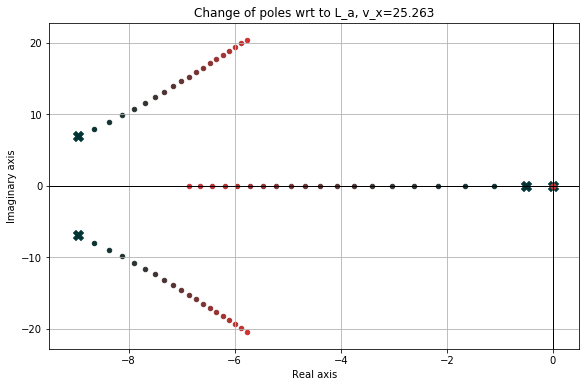

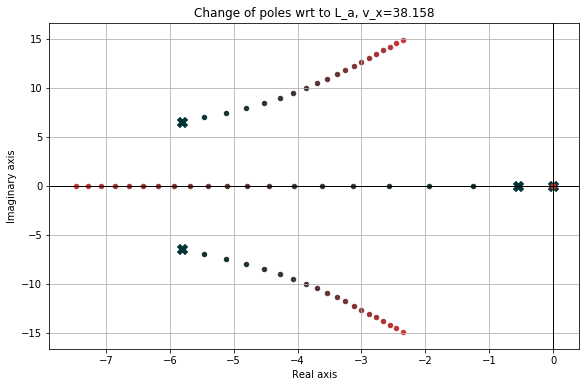

In [7]:
for v_value_index in (2, 7, 11, 18):
    # Chose some v_x, a low value:
    chosen_v = v_values[v_value_index]

    # Create an empty figure
    fig, ax1 = plt.subplots()
    ax1.grid()
    ax1.axhline(color="black", lw=1)
    ax1.axvline(color="black", lw=1)

    # Define color increment
    no_inc = len(pz_wrt_v[chosen_v])
    max_red = 0.8
    inc_value = max_red / (no_inc - 1)
    color_0 = np.array([0, 0.2, 0.2])

    is_first_loop = True
    for L_a in pz_wrt_v[chosen_v]:
        poles, _ = pz_wrt_v[chosen_v][L_a]
        for pole in poles:
            mrk = "X" if is_first_loop else None
            sz = 100 if is_first_loop else 20
            ax1.scatter(np.real(pole), np.imag(pole), color=color_0,
                          marker=mrk, s=sz)
        color_0[0] = color_0[0] + inc_value
        is_first_loop = False

    plt.title("Change of poles wrt to L_a, v_x=" + str(chosen_v.round(3)))
    plt.xlabel("Real axis")
    plt.ylabel("Imaginary axis")
    plt.show()

Similarly, observe the effect of different v_x for some selected L_a;

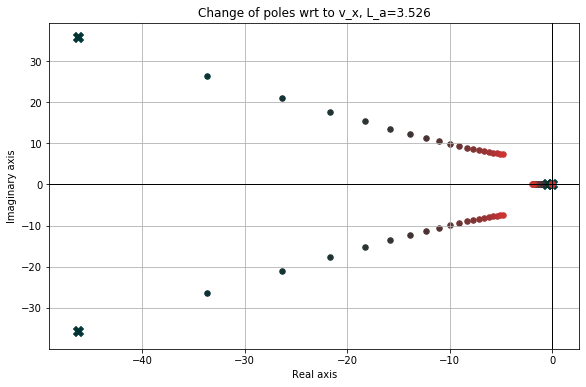

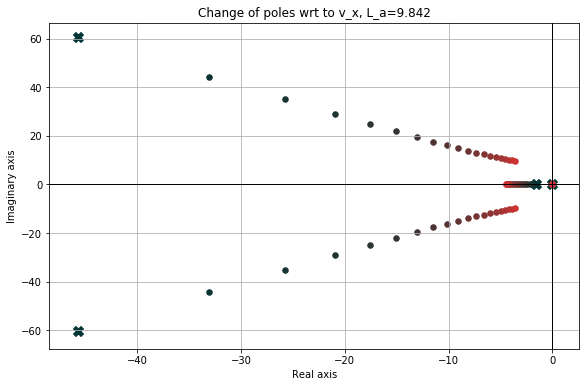

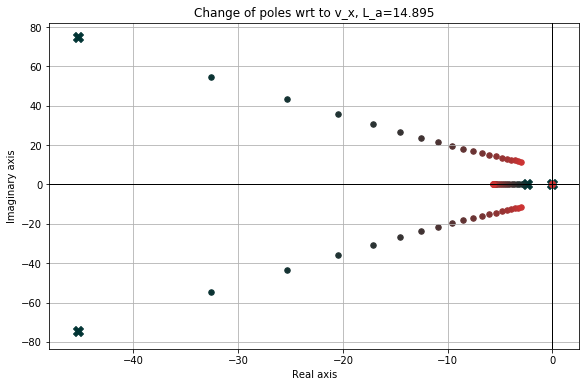

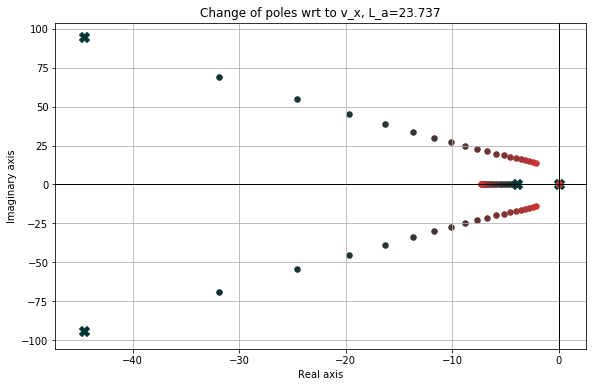

In [8]:
for La_value_index in (2, 7, 11, 18):
    # Chose some v_x, a low value:
    chosen_La = La_values[La_value_index]

    # Create an empty figure
    fig, ax1 = plt.subplots()
    ax1.grid()
    ax1.axhline(color="black", lw=1)
    ax1.axvline(color="black", lw=1)

    # Define color increment
    no_inc = len(pz_wrt_v[chosen_v])
    max_red = 0.8
    inc_value = max_red / (no_inc - 1)
    color_0 = np.array([0, 0.2, 0.2])

    is_first_loop = True
    for v in pz_wrt_La[chosen_La]:
        poles, _ = pz_wrt_La[chosen_La][v]
        for pole in poles:
            mrk = "X" if is_first_loop else None
            sz = 100 if is_first_loop else 30
            ax1.scatter(np.real(pole), np.imag(pole), color=color_0,
                          marker=mrk, s=sz)
        color_0[0] = color_0[0] + inc_value
        is_first_loop = False

    plt.title("Change of poles wrt to v_x, L_a=" + str(chosen_La.round(3)))
    plt.xlabel("Real axis")
    plt.ylabel("Imaginary axis")
    plt.show()

### Effect of $L_{a}$ & $v_{x}$ on $\psi_{el}$

it is possible to observe it, with the same approach. Just define C  properly.

In [15]:
C = np.array([0, 0, 1, 0]).reshape(1, 4)
D = 0
    
v_values = np.linspace(5, 40, 20)
La_values = np.linspace(1, 25, 20)

pz_wrt_v = {}
for v in v_values:
    v_La = {}
    pz_wrt_v[v] = v_La
    for L_a in La_values:        
        A = generate_A(v, L_a)
        B = generate_B(L_a)

        sys = control.ss(A, B, C, D)
        poles, zeros = control.pzmap(sys, Plot=False)
        v_La[L_a] = (poles, zeros)
        
pz_wrt_La = {}
for L_a in La_values:
    La_v = {}
    pz_wrt_La[L_a] = La_v
    for v in v_values:        
        A = generate_A(v, L_a)
        B = generate_B(L_a)

        sys = control.ss(A, B, C, D)
        poles, zeros = control.pzmap(sys, Plot=False)
        La_v[v] = (poles, zeros)

Observe the effect of different L_a for some selected v_x;

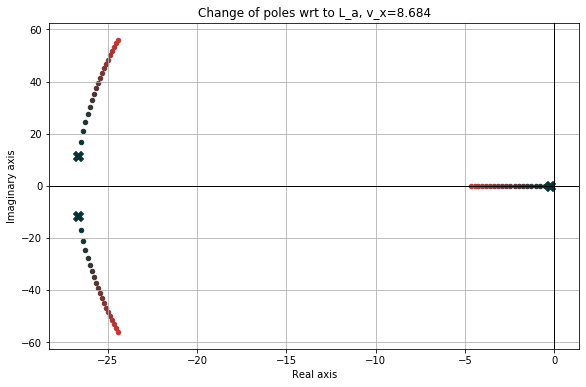

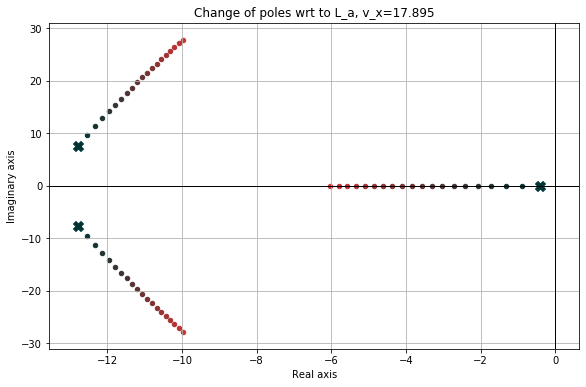

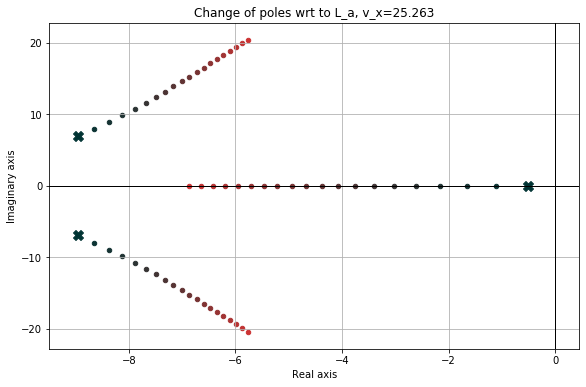

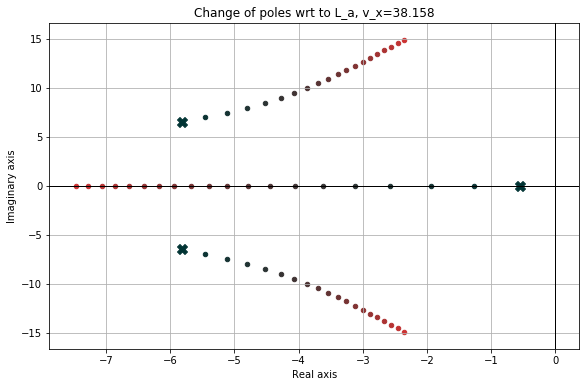

In [16]:
for v_value_index in (2, 7, 11, 18):
    # Chose some v_x, a low value:
    chosen_v = v_values[v_value_index]

    # Create an empty figure
    fig, ax1 = plt.subplots()
    ax1.grid()
    ax1.axhline(color="black", lw=1)
    ax1.axvline(color="black", lw=1)

    # Define color increment
    no_inc = len(pz_wrt_v[chosen_v])
    max_red = 0.8
    inc_value = max_red / (no_inc - 1)
    color_0 = np.array([0, 0.2, 0.2])

    is_first_loop = True
    for L_a in pz_wrt_v[chosen_v]:
        poles, _ = pz_wrt_v[chosen_v][L_a]
        for pole in poles:
            mrk = "X" if is_first_loop else None
            sz = 100 if is_first_loop else 20
            ax1.scatter(np.real(pole), np.imag(pole), color=color_0,
                          marker=mrk, s=sz)
        color_0[0] = color_0[0] + inc_value
        is_first_loop = False

    plt.title("Change of poles wrt to L_a, v_x=" + str(chosen_v.round(3)))
    plt.xlabel("Real axis")
    plt.ylabel("Imaginary axis")
    plt.show()

Similarly, observe the effect of different v_x for some selected L_a;

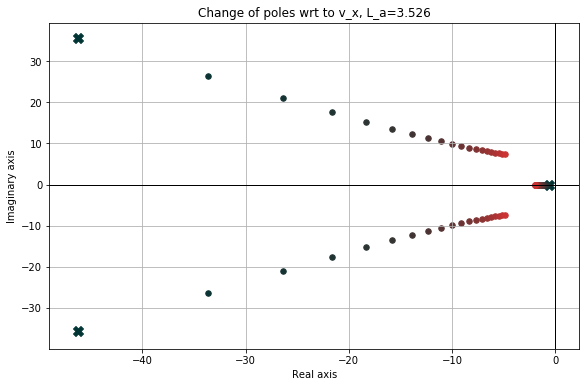

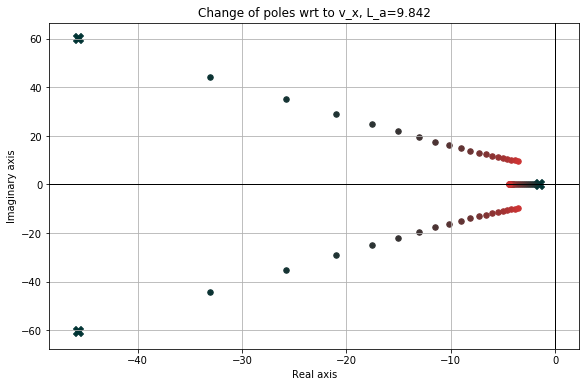

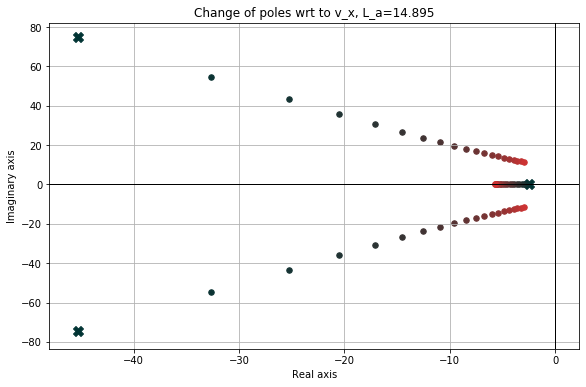

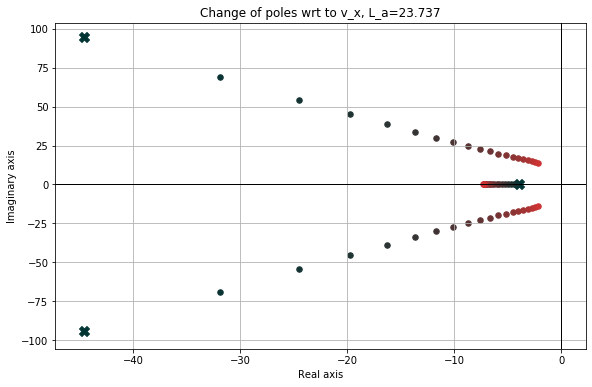

In [14]:
for La_value_index in (2, 7, 11, 18):
    # Chose some v_x, a low value:
    chosen_La = La_values[La_value_index]

    # Create an empty figure
    fig, ax1 = plt.subplots()
    ax1.grid()
    ax1.axhline(color="black", lw=1)
    ax1.axvline(color="black", lw=1)

    # Define color increment
    no_inc = len(pz_wrt_v[chosen_v])
    max_red = 0.8
    inc_value = max_red / (no_inc - 1)
    color_0 = np.array([0, 0.2, 0.2])

    is_first_loop = True
    for v in pz_wrt_La[chosen_La]:
        poles, _ = pz_wrt_La[chosen_La][v]
        for pole in poles:
            mrk = "X" if is_first_loop else None
            sz = 100 if is_first_loop else 30
            ax1.scatter(np.real(pole), np.imag(pole), color=color_0,
                          marker=mrk, s=sz)
        color_0[0] = color_0[0] + inc_value
        is_first_loop = False

    plt.title("Change of poles wrt to v_x, L_a=" + str(chosen_La.round(3)))
    plt.xlabel("Real axis")
    plt.ylabel("Imaginary axis")
    plt.show()